In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(123)

In [2]:
df = pd.read_csv('./data/apartments.csv')

In [3]:
df.head()

,m2.price,construction.year,surface,floor,no.rooms,district
0,5897,1953,25,3,1,Srodmiescie
1,1818,1992,143,9,5,Bielany
2,3643,1937,56,1,2,Praga
3,3517,1995,93,7,3,Ochota
4,3013,1992,144,6,5,Mokotow


### Problem
The data is not in a numeric array format, there are *factors*, so we need to fix them.

#### First strategy: Mapping between integers and values

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
le = LabelEncoder()

In [6]:
le.fit_transform(df['district']);

In [7]:
le.classes_

array(['Bemowo', 'Bielany', 'Mokotow', 'Ochota', 'Praga', 'Srodmiescie',
       'Ursus', 'Ursynow', 'Wola', 'Zoliborz'], dtype=object)

In [8]:
le.inverse_transform([5])

array(['Srodmiescie'], dtype=object)

In [9]:
X_le = df.iloc[:,1:]

In [10]:
X_le.head()

,construction.year,surface,floor,no.rooms,district
0,1953,25,3,1,Srodmiescie
1,1992,143,9,5,Bielany
2,1937,56,1,2,Praga
3,1995,93,7,3,Ochota
4,1992,144,6,5,Mokotow


In [11]:
X_le['district_encoded'] = le.fit_transform(df['district'])

In [12]:
X_le.head()

,construction.year,surface,floor,no.rooms,district,district_encoded
0,1953,25,3,1,Srodmiescie,5
1,1992,143,9,5,Bielany,1
2,1937,56,1,2,Praga,4
3,1995,93,7,3,Ochota,3
4,1992,144,6,5,Mokotow,2


In [13]:
X_le.drop('district', axis=1, inplace=True)

In [14]:
X_le.head()

,construction.year,surface,floor,no.rooms,district_encoded
0,1953,25,3,1,5
1,1992,143,9,5,1
2,1937,56,1,2,4
3,1995,93,7,3,3
4,1992,144,6,5,2


In [15]:
y = df['m2.price']

From here on, business as usual: train/test split, create pipelines, evaluate, ...

### Second strategy: One-hot encoding

In [16]:
X_oh = pd.get_dummies(df) # 

In [17]:
X_oh.head()

,m2.price,construction.year,surface,floor,no.rooms,district_Bemowo,district_Bielany,district_Mokotow,district_Ochota,district_Praga,district_Srodmiescie,district_Ursus,district_Ursynow,district_Wola,district_Zoliborz
0,5897,1953,25,3,1,0,0,0,0,0,1,0,0,0,0
1,1818,1992,143,9,5,0,1,0,0,0,0,0,0,0,0
2,3643,1937,56,1,2,0,0,0,0,1,0,0,0,0,0
3,3517,1995,93,7,3,0,0,0,1,0,0,0,0,0,0
4,3013,1992,144,6,5,0,0,1,0,0,0,0,0,0,0


# Decision Trees & Random Forests

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
dt = DecisionTreeClassifier()

In [20]:
df.head()

,m2.price,construction.year,surface,floor,no.rooms,district
0,5897,1953,25,3,1,Srodmiescie
1,1818,1992,143,9,5,Bielany
2,3643,1937,56,1,2,Praga
3,3517,1995,93,7,3,Ochota
4,3013,1992,144,6,5,Mokotow


In [21]:
y = le.fit_transform(df['district'])

In [22]:
X = df.iloc[:,:-1]

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)

In [24]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [25]:
depths = [2,4,8,16, 32, 64]
scores = []
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    scores.append(dt.score(X_test, y_test))

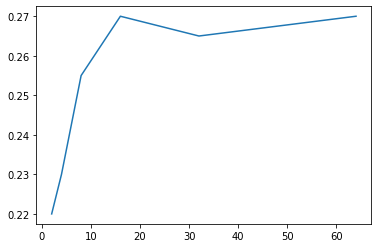

In [26]:
plt.plot(depths, scores)

In [27]:
dt.score(X_train, y_train)

0.99875

In [28]:
dt.score(X_test, y_test)

0.27

In [29]:
df.shape

(1000, 6)

#### Problem: Decision trees are very prone to overfitting!

Workaround: 
- Use small decision trees (small = with `max_depth` small).
- Train those decision trees in random subsamples of the data.
- Final prediction is the combined prediction of all the trees.

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rf = RandomForestClassifier(n_estimators=30, max_depth=3) #Usually n_estimators is of order 100-500

In [32]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=30)

In [33]:
rf.score(X_test, y_test)

0.22

In [34]:
rf.feature_importances_

array([0.67271345, 0.10960883, 0.10663042, 0.05648532, 0.05456199])

In [35]:
X_train.head()

,m2.price,construction.year,surface,floor,no.rooms
512,2926,1991,87,4,4
685,1837,1977,131,10,5
997,3098,1980,85,3,3
927,2154,1970,140,6,5
376,3049,1980,40,9,1


In [36]:
cols = X_train.columns.values

<BarContainer object of 5 artists>

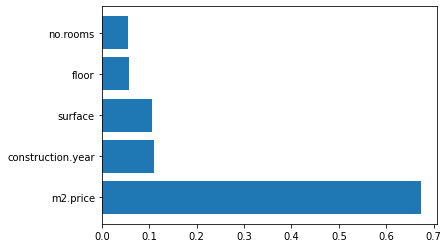

In [37]:
plt.barh(cols, rf.feature_importances_)

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 3,  0,  1,  0,  0,  0,  0,  3,  8,  2],
       [ 8,  1,  1,  0,  0,  0,  1,  2,  8,  1],
       [ 1,  0,  1,  5,  0,  2,  0,  1,  5,  8],
       [ 1,  0,  3,  2,  0,  6,  1,  3,  2,  7],
       [ 5,  0,  0,  0,  0,  0,  3,  5,  7,  2],
       [ 0,  0,  0,  0,  0, 19,  0,  0,  0,  1],
       [ 5,  0,  1,  1,  0,  0,  3,  2,  7,  0],
       [ 5,  0,  0,  0,  0,  0,  3,  3,  5,  1],
       [ 1,  0,  4,  0,  0,  0,  3,  5,  6,  1],
       [ 2,  0,  4,  0,  0,  1,  0,  0,  2,  6]], dtype=int64)